# BLE Proximity Experiment - SVM Classifier
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [2]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [3]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Initialize Dataset
Initialization of the data from the file

In [4]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
#distance_proximity_experiments were made with purple beacon
display(dataset)
display(dataset.shape)

coordinate_X  coordinate_Y  rssi_Value  rolling_mean_rssi        zone  \
0             0.0           0.0         -50         -50.000000  0-1 meters   
1             0.0           0.0         -50         -50.000000  0-1 meters   
2             0.0           0.0         -53         -51.000000  0-1 meters   
3             0.0           0.0         -51         -51.000000  0-1 meters   
4             0.0           0.0         -53         -53.000000  0-1 meters   
..            ...           ...         ...                ...         ...   
456           0.0           4.0         -83         -84.250000  3-4 meters   
457           0.0           4.0         -86         -84.600000  3-4 meters   
458           0.0           4.0         -87         -85.000000  3-4 meters   
459           0.0           4.0         -86         -85.142857  3-4 meters   
460           0.0           4.0         -87         -85.375000  3-4 meters   

     distance  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
..        ...  
456       4.0  
457       4.0  
458       4.0  
459       4.0  
460       4.0  

[461 rows x 6 columns]

(461, 6)

### File Overall Description
Usage of describe pandas function on the dataset

In [5]:
display(dataset.describe().transpose())

count       mean       std   min   25%    50%   75%   max
coordinate_X       461.0   0.000000  0.000000   0.0   0.0   0.00   0.0   0.0
coordinate_Y       461.0   1.973970  1.274489   0.0   1.0   2.00   3.0   4.0
rssi_Value         461.0 -78.206074  9.461756 -94.0 -85.0 -81.00 -75.0 -50.0
rolling_mean_rssi  461.0 -78.065939  9.240107 -91.0 -84.0 -81.25 -76.0 -50.0
distance           461.0   1.973970  1.274489   0.0   1.0   2.00   3.0   4.0

### Scanned Zones
Graphical display of the zones scanned in the experiment

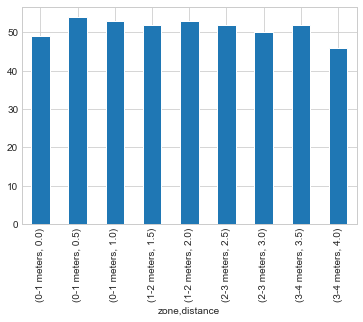

In [7]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

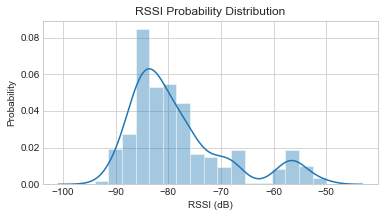

In [8]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

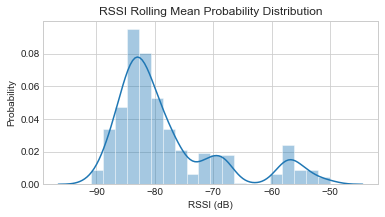

In [9]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

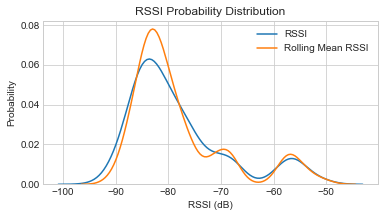

In [11]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Initialize Training Data
Training Data intialization for predictions purposes

In [15]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
train_Y = pd.DataFrame(dataset['zone']).values.reshape(-1,1)
default_groups = dataset['zone'].map(str)
data_plot_means = dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

# FREE PARAMETERS
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
C_parameter_list = [0.25,0.5,1.0,10.0,100.0,1000.0] 
kernel_list = ("linear","poly","rbf","sigmoid")
gamma_list = [10,100,"scale","auto"]
class_weights_list = ["balanced",None]
decision_function_shape_list = ["ovo","ovr"]

rssi_Value  rolling_mean_rssi
zone                                     
0-1 meters  -69.205128         -69.220368
1-2 meters  -79.952381         -79.981444
2-3 meters  -84.107843         -84.048751
3-4 meters  -84.520408         -83.867310

### Plot Training Data
Graphical Display of the observations in the dataset

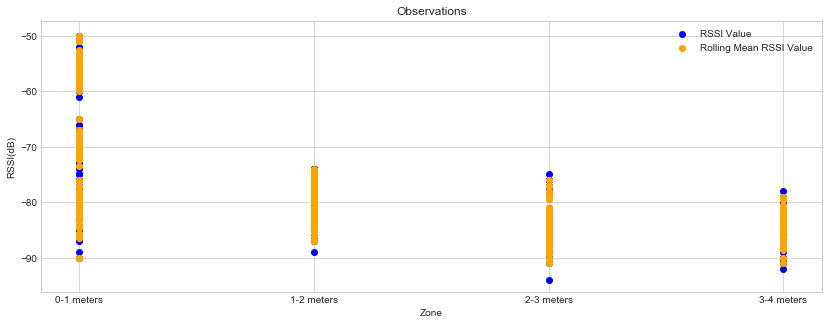

In [13]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [14]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

### SVM Classifier Experiments
Experiments with SVC algorithm

In [21]:
def compute_SVM_with_Classifier(flag=0,colors=None,trainX_data = None,fold=None, trainY_data = None,testX_data = None,testY_data = None, scaler = None,
                                cross_validation = None,C_parameter = 1.0, kernel_parameter='rbf', gamma_parameter="scale",
                                class_weigth_parameter=None, decision_function_shape_parameter='ovr'):
    svm_classifier_estimator = SVC(C=C_parameter,kernel=kernel_parameter,gamma=gamma_parameter,class_weight=class_weigth_parameter,
                                  decision_function_shape=decision_function_shape_parameter,random_state = 6)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,svm_classifier_estimator)
    else:
        main_estimator = svm_classifier_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        main_estimator.fit(testX_data,testY_data)
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    statistical_array = list()
    statistics = pd.DataFrame(report).transpose()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        plt.figure(figsize=(18,10))
        plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
        plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
        if colors is not None:
            plt.plot(predict_test, testX_data,'s',color=colors,label='SVM Classification' + ' CV : ' +str(fold))
        else:
            plt.plot(predict_test, testX_data,'s',color='red',label='SVM Classification')
        # Show and place the legent
        plt.legend(loc='upper right')
        plt.show()
    error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
    result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())

#### 1st Experiment - Check Overfitting scenario (Without Testing Data) Using RSSI
Use SVC to check the results on the training data alone

Confusion Matrix:
[[101  34   3  18]
 [  0  67   2  36]
 [  0  21  28  53]
 [  0  16  25  57]]


precision    recall  f1-score     support
0-1 meters     1.000000  0.647436  0.785992  156.000000
1-2 meters     0.485507  0.638095  0.551440  105.000000
2-3 meters     0.482759  0.274510  0.350000  102.000000
3-4 meters     0.347561  0.581633  0.435115   98.000000
accuracy       0.548807  0.548807  0.548807    0.548807
macro avg      0.578957  0.535418  0.530637  461.000000
weighted avg   0.629676  0.548807  0.561512  461.000000

Actual   Predicted
0    0-1 meters  0-1 meters
1    0-1 meters  0-1 meters
2    0-1 meters  0-1 meters
3    0-1 meters  0-1 meters
4    0-1 meters  0-1 meters
..          ...         ...
456  3-4 meters  3-4 meters
457  3-4 meters  3-4 meters
458  3-4 meters  2-3 meters
459  3-4 meters  3-4 meters
460  3-4 meters  2-3 meters

[461 rows x 2 columns]

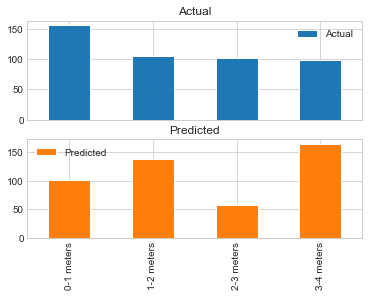

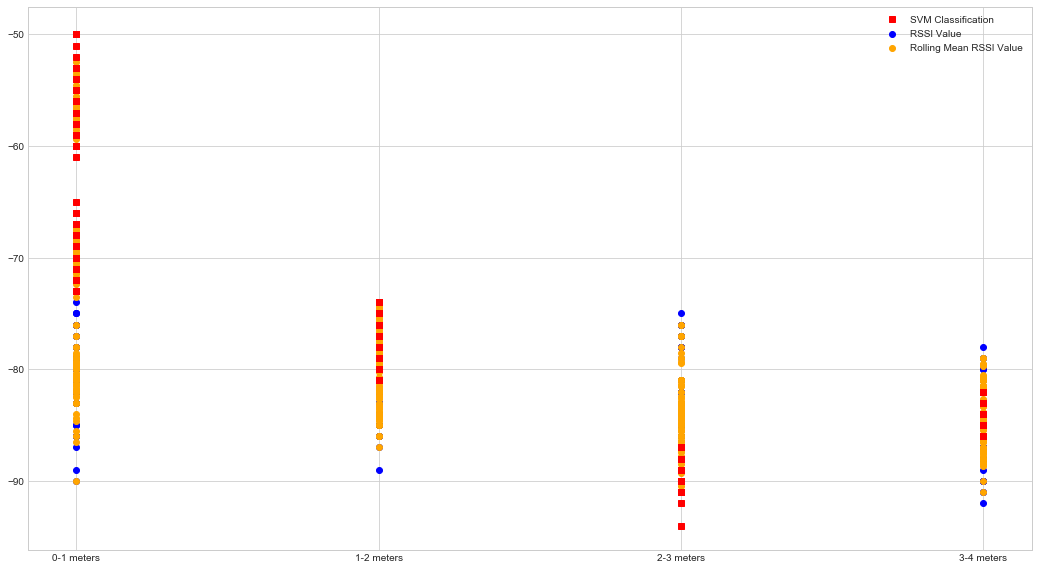

mae       mse      rmse  precision  accuracy  f1-score
0  0.451193  0.451193  0.671709   0.581895  0.548807  0.537643

In [22]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_SVM_with_Classifier(flag=1,trainX_data=train_X_rssi,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rssi,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 2nd Experiment - Check Overfitting scenario (Without Testing Data) Using Rolling Mean
Use SVC to check the results on the training data alone

Confusion Matrix:
[[103  26   5  22]
 [  0  62   4  39]
 [  0  11  34  57]
 [  0   8  23  67]]


precision    recall  f1-score     support
0-1 meters     1.000000  0.660256  0.795367  156.000000
1-2 meters     0.579439  0.590476  0.584906  105.000000
2-3 meters     0.515152  0.333333  0.404762  102.000000
3-4 meters     0.362162  0.683673  0.473498   98.000000
accuracy       0.577007  0.577007  0.577007    0.577007
macro avg      0.614188  0.566935  0.564633  461.000000
weighted avg   0.661342  0.577007  0.592583  461.000000

Actual   Predicted
0    0-1 meters  0-1 meters
1    0-1 meters  0-1 meters
2    0-1 meters  0-1 meters
3    0-1 meters  0-1 meters
4    0-1 meters  0-1 meters
..          ...         ...
456  3-4 meters  3-4 meters
457  3-4 meters  3-4 meters
458  3-4 meters  3-4 meters
459  3-4 meters  3-4 meters
460  3-4 meters  3-4 meters

[461 rows x 2 columns]

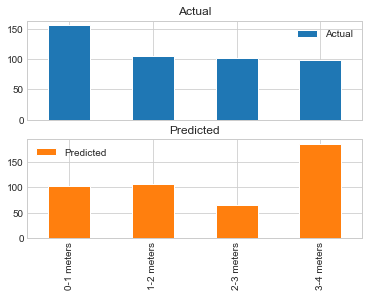

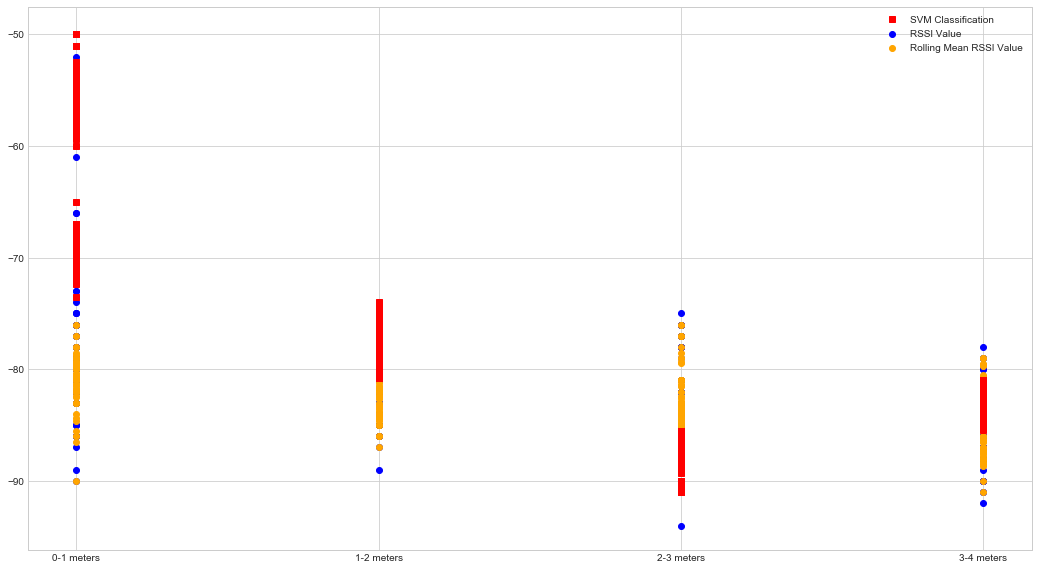

mae       mse      rmse  precision  accuracy  f1-score
0  0.422993  0.422993  0.650379   0.615613  0.577007  0.570394

In [23]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_SVM_with_Classifier(flag=1,trainX_data=train_X_rolling_mean,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 3rd Experiment - SVC with StratifiedKFold (RSSI pure)
Experiment using cross validation approach of StratifiedKFold

Confusion Matrix:
[[102  21   3  30]
 [ 42  19   4  40]
 [ 16   8  24  54]
 [  6  26  27  39]]


precision    recall  f1-score     support
0-1 meters     0.614458  0.653846  0.633540  156.000000
1-2 meters     0.256757  0.180952  0.212291  105.000000
2-3 meters     0.413793  0.235294  0.300000  102.000000
3-4 meters     0.239264  0.397959  0.298851   98.000000
accuracy       0.399132  0.399132  0.399132    0.399132
macro avg      0.381068  0.367013  0.361170  461.000000
weighted avg   0.408828  0.399132  0.392647  461.000000

Actual   Predicted
0    0-1 meters  0-1 meters
1    0-1 meters  0-1 meters
2    0-1 meters  0-1 meters
3    0-1 meters  0-1 meters
4    0-1 meters  0-1 meters
..          ...         ...
456  3-4 meters  3-4 meters
457  3-4 meters  3-4 meters
458  3-4 meters  2-3 meters
459  3-4 meters  3-4 meters
460  3-4 meters  2-3 meters

[461 rows x 2 columns]

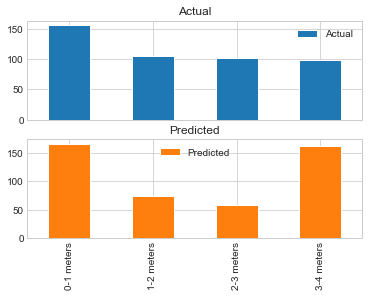

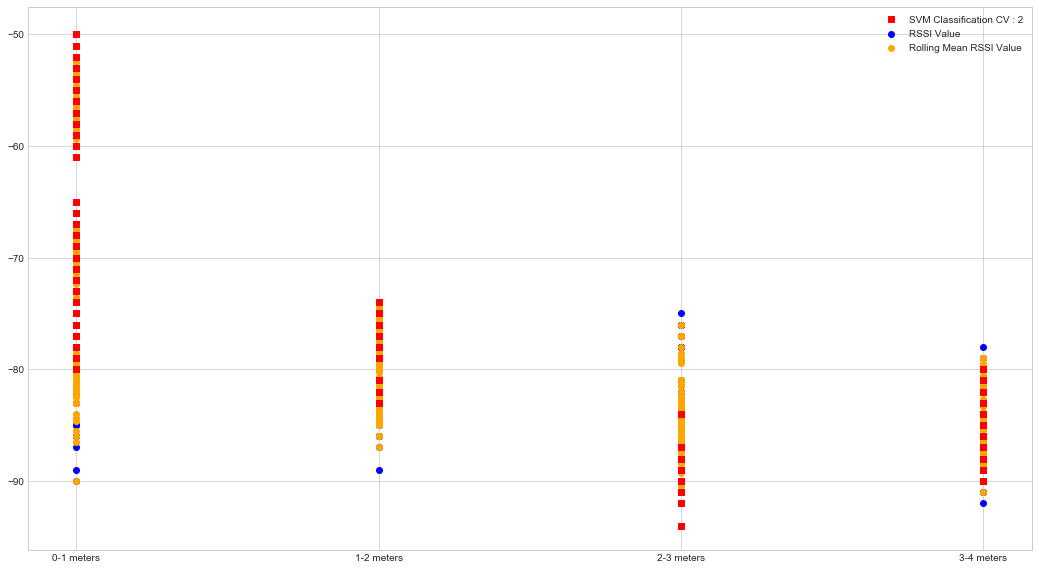

Confusion Matrix:
[[60 70  0 26]
 [20 43  3 39]
 [ 6 12  5 79]
 [ 0 17 26 55]]


precision    recall  f1-score     support
0-1 meters     0.697674  0.384615  0.495868  156.000000
1-2 meters     0.302817  0.409524  0.348178  105.000000
2-3 meters     0.147059  0.049020  0.073529  102.000000
3-4 meters     0.276382  0.561224  0.370370   98.000000
accuracy       0.353579  0.353579  0.353579    0.353579
macro avg      0.355983  0.351096  0.321986  461.000000
weighted avg   0.396352  0.353579  0.342105  461.000000

Actual   Predicted
0    0-1 meters  0-1 meters
1    0-1 meters  0-1 meters
2    0-1 meters  0-1 meters
3    0-1 meters  0-1 meters
4    0-1 meters  0-1 meters
..          ...         ...
456  3-4 meters  3-4 meters
457  3-4 meters  3-4 meters
458  3-4 meters  3-4 meters
459  3-4 meters  3-4 meters
460  3-4 meters  3-4 meters

[461 rows x 2 columns]

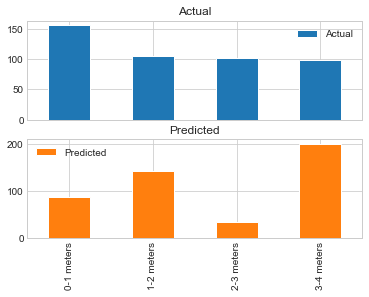

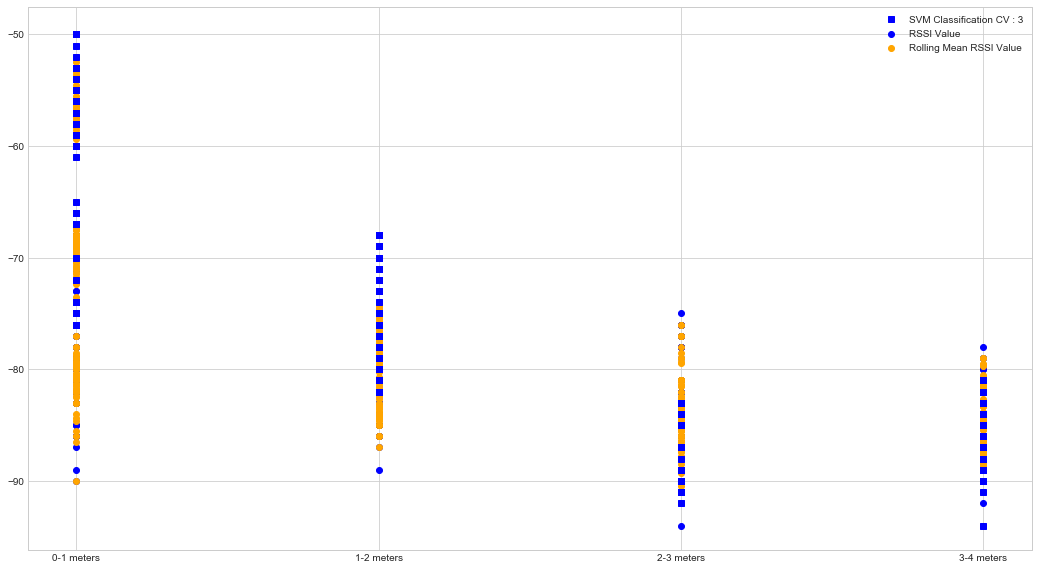

Confusion Matrix:
[[90 40  1 25]
 [ 6 59  1 39]
 [ 0 21  4 77]
 [ 0 26 18 54]]


precision    recall  f1-score     support
0-1 meters     0.937500  0.576923  0.714286  156.000000
1-2 meters     0.404110  0.561905  0.470120  105.000000
2-3 meters     0.166667  0.039216  0.063492  102.000000
3-4 meters     0.276923  0.551020  0.368601   98.000000
accuracy       0.449024  0.449024  0.449024    0.449024
macro avg      0.446300  0.432266  0.404124  461.000000
weighted avg   0.505032  0.449024  0.441193  461.000000

Actual   Predicted
0    0-1 meters  0-1 meters
1    0-1 meters  0-1 meters
2    0-1 meters  0-1 meters
3    0-1 meters  0-1 meters
4    0-1 meters  0-1 meters
..          ...         ...
456  3-4 meters  3-4 meters
457  3-4 meters  3-4 meters
458  3-4 meters  3-4 meters
459  3-4 meters  3-4 meters
460  3-4 meters  3-4 meters

[461 rows x 2 columns]

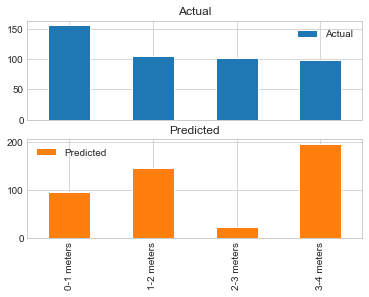

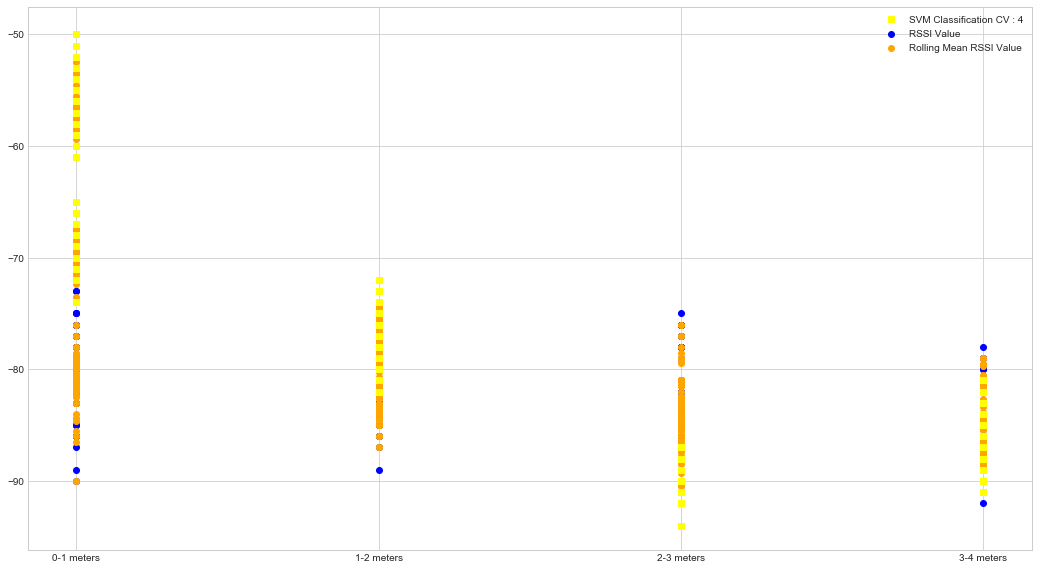

Confusion Matrix:
[[100  34   1  21]
 [  5  62   0  38]
 [  0  19   5  78]
 [  0  23  18  57]]


precision    recall  f1-score   support
0-1 meters     0.952381  0.641026  0.766284  156.0000
1-2 meters     0.449275  0.590476  0.510288  105.0000
2-3 meters     0.208333  0.049020  0.079365  102.0000
3-4 meters     0.293814  0.581633  0.390411   98.0000
accuracy       0.485900  0.485900  0.485900    0.4859
macro avg      0.475951  0.465539  0.436587  461.0000
weighted avg   0.533165  0.485900  0.476087  461.0000

Actual   Predicted
0    0-1 meters  0-1 meters
1    0-1 meters  0-1 meters
2    0-1 meters  0-1 meters
3    0-1 meters  0-1 meters
4    0-1 meters  0-1 meters
..          ...         ...
456  3-4 meters  3-4 meters
457  3-4 meters  3-4 meters
458  3-4 meters  3-4 meters
459  3-4 meters  3-4 meters
460  3-4 meters  3-4 meters

[461 rows x 2 columns]

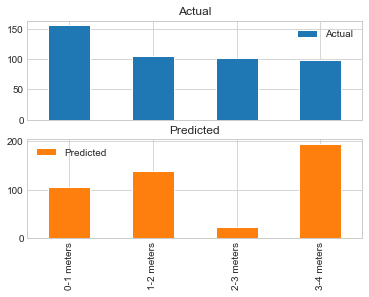

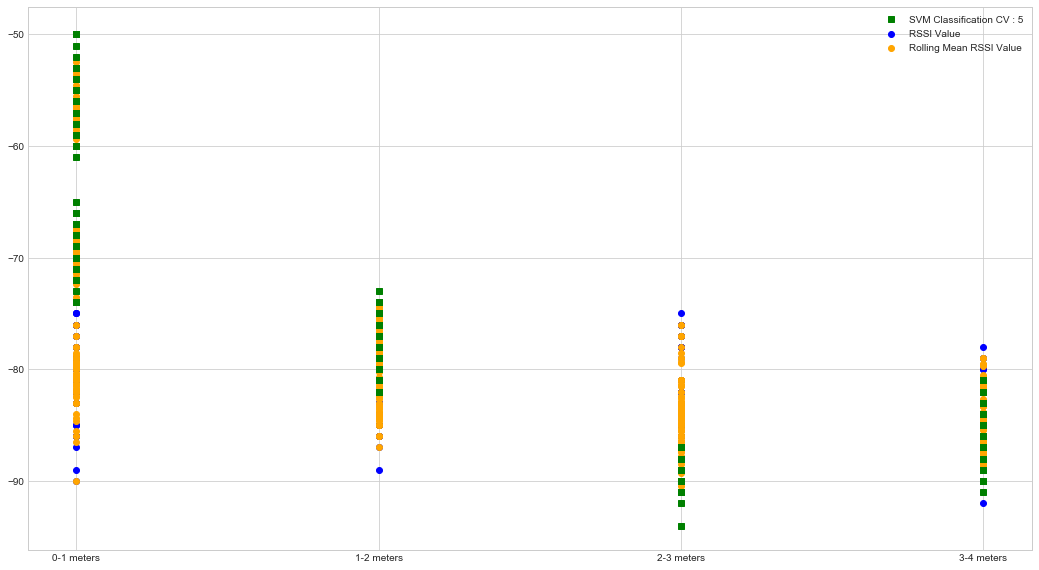

mae       mse      rmse  precision  accuracy  f1-score  folds
3  0.514100  0.514100  0.717008   0.485546  0.485900  0.449274      5
2  0.550976  0.550976  0.742278   0.455079  0.449024  0.415834      4
0  0.600868  0.600868  0.775157   0.387614  0.399132  0.371090      2
1  0.646421  0.646421  0.804003   0.361407  0.353579  0.329374      3

Number of Folds:  5


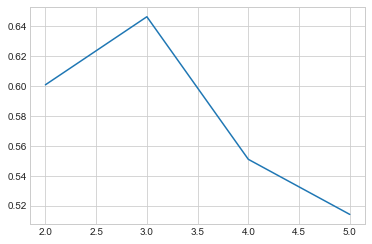

In [26]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,6)
colors = ['red','blue','yellow','green']
counter = 0
results = list()
for cv in cross_validation_list:
    result = compute_SVM_with_Classifier(flag = 1,colors=colors[counter],fold=cv,testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 4th Experiment - SVC with StratifiedKFold (Rolling Mean)
Experiment using cross validation approach of StratifiedKFold

Confusion Matrix:
[[103   8   5  40]
 [ 43  15  12  35]
 [ 21  12  48  21]
 [ 33   8  41  16]]


precision    recall  f1-score     support
0-1 meters     0.515000  0.660256  0.578652  156.000000
1-2 meters     0.348837  0.142857  0.202703  105.000000
2-3 meters     0.452830  0.470588  0.461538  102.000000
3-4 meters     0.142857  0.163265  0.152381   98.000000
accuracy       0.394794  0.394794  0.394794    0.394794
macro avg      0.364881  0.359242  0.348818  461.000000
weighted avg   0.384288  0.394794  0.376494  461.000000

Actual   Predicted
0    0-1 meters  0-1 meters
1    0-1 meters  0-1 meters
2    0-1 meters  0-1 meters
3    0-1 meters  0-1 meters
4    0-1 meters  0-1 meters
..          ...         ...
456  3-4 meters  3-4 meters
457  3-4 meters  3-4 meters
458  3-4 meters  2-3 meters
459  3-4 meters  2-3 meters
460  3-4 meters  2-3 meters

[461 rows x 2 columns]

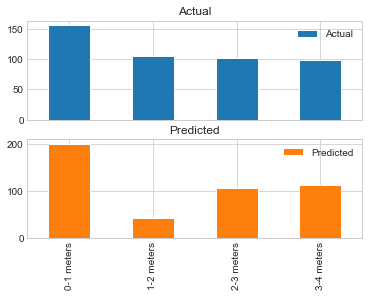

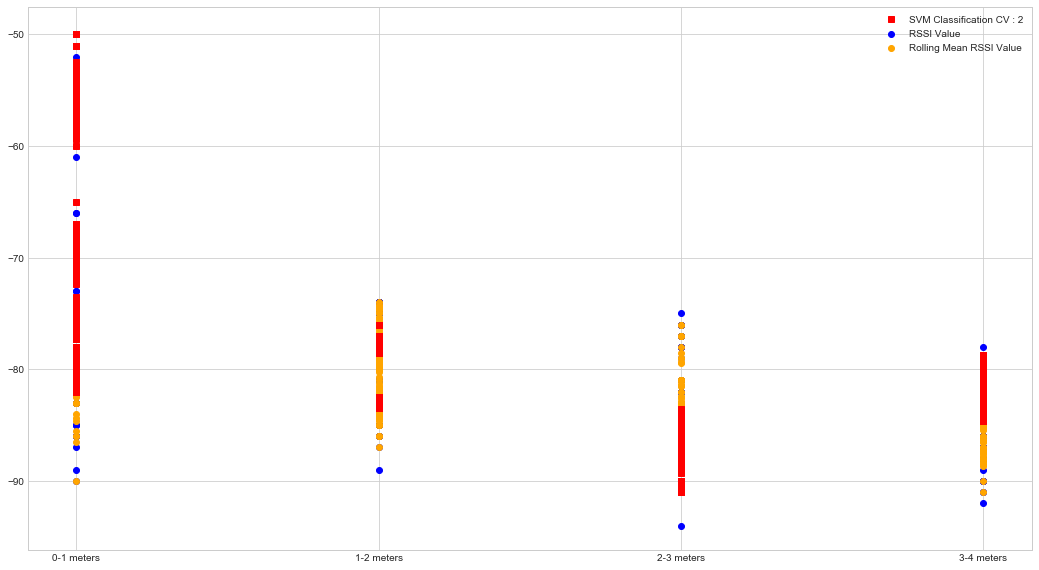

Confusion Matrix:
[[55 70 31  0]
 [10 53 20 22]
 [ 2 22 52 26]
 [ 1 29 48 20]]


precision    recall  f1-score     support
0-1 meters     0.808824  0.352564  0.491071  156.000000
1-2 meters     0.304598  0.504762  0.379928  105.000000
2-3 meters     0.344371  0.509804  0.411067  102.000000
3-4 meters     0.294118  0.204082  0.240964   98.000000
accuracy       0.390456  0.390456  0.390456    0.390456
macro avg      0.437977  0.392803  0.380758  461.000000
weighted avg   0.481797  0.390456  0.394887  461.000000

Actual   Predicted
0    0-1 meters  0-1 meters
1    0-1 meters  0-1 meters
2    0-1 meters  0-1 meters
3    0-1 meters  0-1 meters
4    0-1 meters  0-1 meters
..          ...         ...
456  3-4 meters  2-3 meters
457  3-4 meters  2-3 meters
458  3-4 meters  2-3 meters
459  3-4 meters  2-3 meters
460  3-4 meters  2-3 meters

[461 rows x 2 columns]

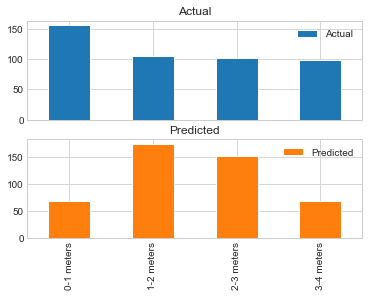

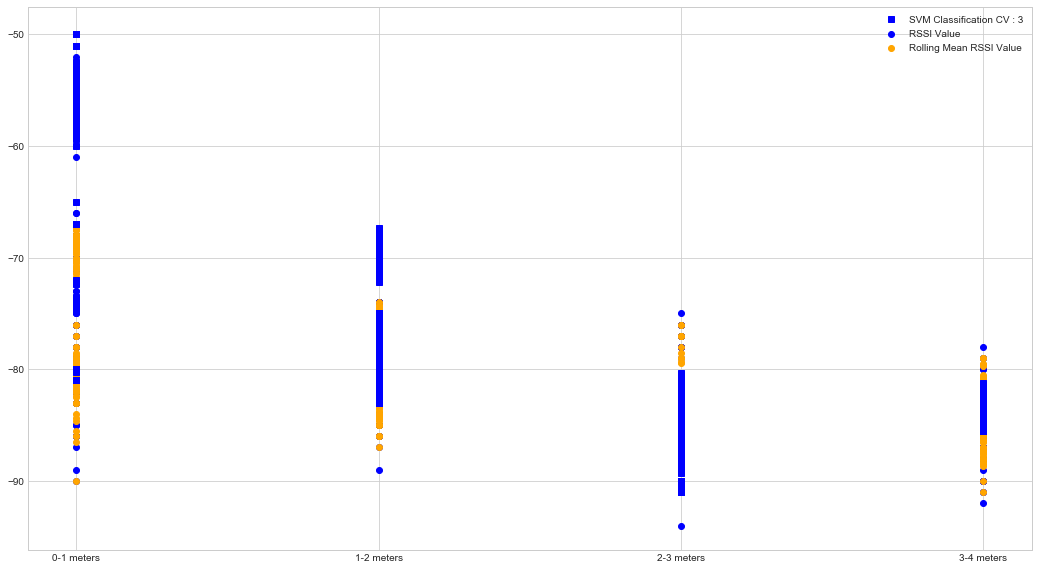

Confusion Matrix:
[[93 35 19  9]
 [ 0 64 20 21]
 [ 2 18 39 43]
 [ 1 22 54 21]]


precision    recall  f1-score     support
0-1 meters     0.968750  0.596154  0.738095  156.000000
1-2 meters     0.460432  0.609524  0.524590  105.000000
2-3 meters     0.295455  0.382353  0.333333  102.000000
3-4 meters     0.223404  0.214286  0.218750   98.000000
accuracy       0.470716  0.470716  0.470716    0.470716
macro avg      0.487010  0.450579  0.453692  461.000000
weighted avg   0.545554  0.470716  0.489506  461.000000

Actual   Predicted
0    0-1 meters  0-1 meters
1    0-1 meters  0-1 meters
2    0-1 meters  0-1 meters
3    0-1 meters  0-1 meters
4    0-1 meters  0-1 meters
..          ...         ...
456  3-4 meters  2-3 meters
457  3-4 meters  2-3 meters
458  3-4 meters  2-3 meters
459  3-4 meters  2-3 meters
460  3-4 meters  2-3 meters

[461 rows x 2 columns]

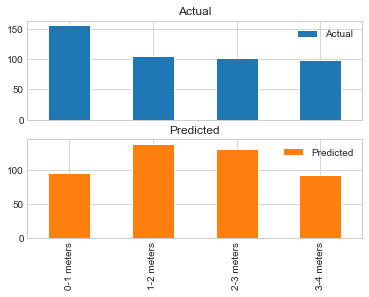

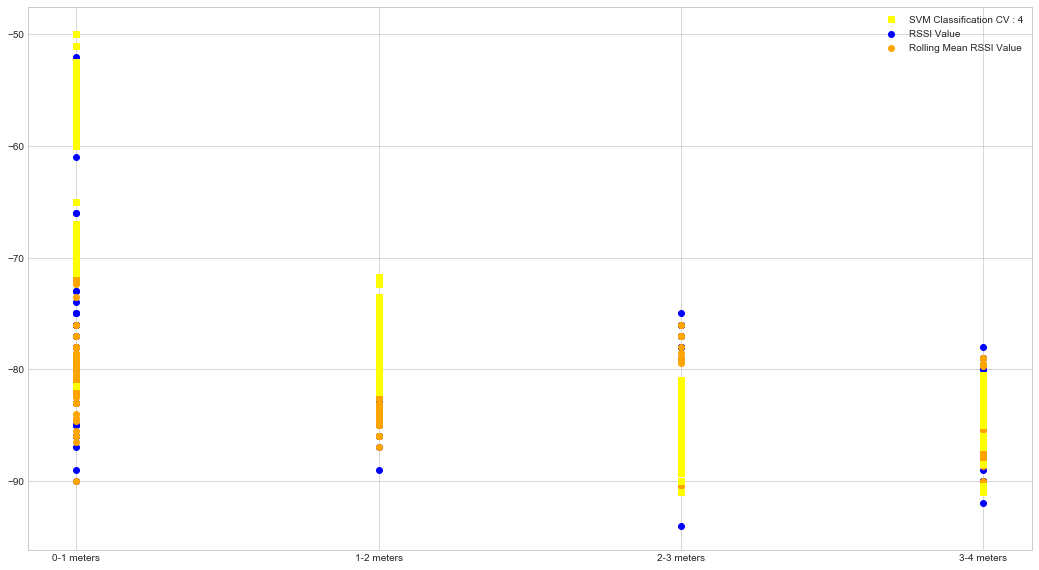

Confusion Matrix:
[[102  27  13  14]
 [  0  60  14  31]
 [  0  20  23  59]
 [  0  21  44  33]]


precision    recall  f1-score     support
0-1 meters     1.000000  0.653846  0.790698  156.000000
1-2 meters     0.468750  0.571429  0.515021  105.000000
2-3 meters     0.244681  0.225490  0.234694  102.000000
3-4 meters     0.240876  0.336735  0.280851   98.000000
accuracy       0.472885  0.472885  0.472885    0.472885
macro avg      0.488577  0.446875  0.455316  461.000000
weighted avg   0.550503  0.472885  0.496504  461.000000

Actual   Predicted
0    0-1 meters  0-1 meters
1    0-1 meters  0-1 meters
2    0-1 meters  0-1 meters
3    0-1 meters  0-1 meters
4    0-1 meters  0-1 meters
..          ...         ...
456  3-4 meters  2-3 meters
457  3-4 meters  2-3 meters
458  3-4 meters  2-3 meters
459  3-4 meters  2-3 meters
460  3-4 meters  2-3 meters

[461 rows x 2 columns]

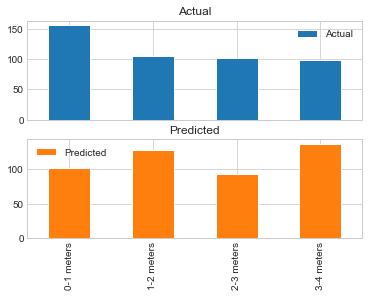

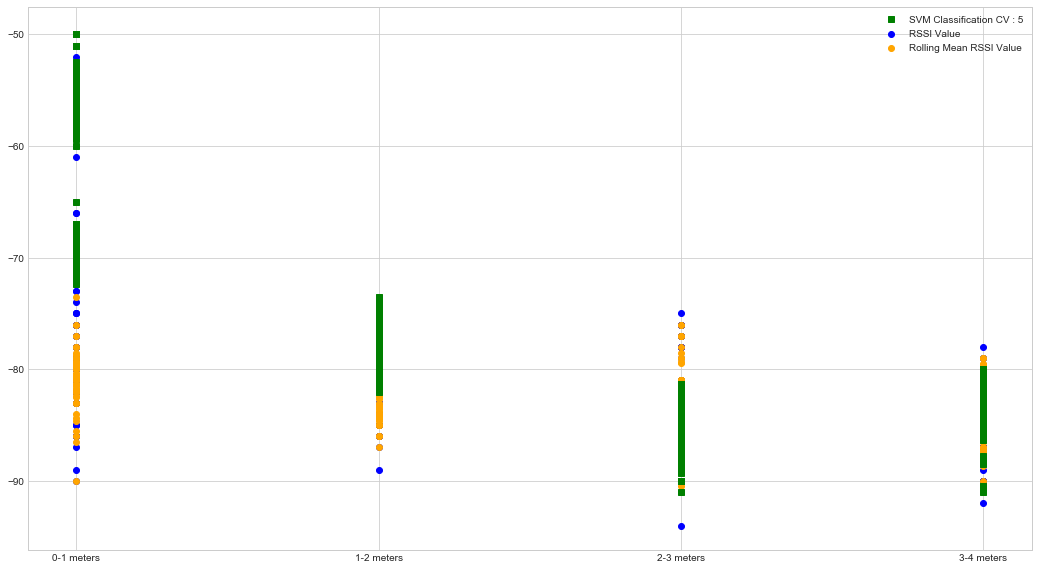

mae       mse      rmse  precision  accuracy  f1-score  folds
3  0.527115  0.527115  0.726027   0.495182  0.472885  0.463710      5
2  0.529284  0.529284  0.727519   0.493046  0.470716  0.461240      4
0  0.605206  0.605206  0.777950   0.371927  0.394794  0.359340      2
1  0.609544  0.609544  0.780733   0.437449  0.390456  0.384162      3

Number of Folds:  5


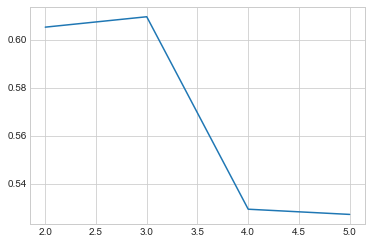

In [27]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,6)
colors = ['red','blue','yellow','green']
counter = 0
results = list()
for cv in cross_validation_list:
    result = compute_SVM_with_Classifier(flag = 1,colors=colors[counter],fold=cv,testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 5th Experiment - SVC with HoldOut (RSSI pure)
Experiment using cross validation approach of HoldOut (Train test split)

mae       mse      rmse  precision  accuracy  f1-score  test_size
5  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075        0.6
3  0.459459  0.459459  0.677834   0.581660  0.540541  0.529484        0.4
6  0.461300  0.461300  0.679191   0.577263  0.538700  0.516341        0.7
4  0.463203  0.463203  0.680591   0.592912  0.536797  0.516306        0.5
2  0.474820  0.474820  0.689072   0.575810  0.525180  0.513125        0.3
0  0.489362  0.489362  0.699544   0.520438  0.510638  0.488402        0.1
1  0.505376  0.505376  0.710898   0.541965  0.494624  0.482303        0.2
8  0.469880  0.469880  0.685478   0.559208  0.530120  0.476455        0.9
7  0.468835  0.468835  0.684715   0.572430  0.531165  0.472723        0.8

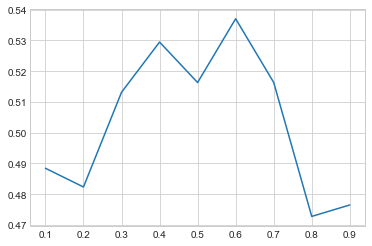

In [28]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rssi,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### 6th Experiment - SVC with HoldOut (Rolling Mean)
Experiment using cross validation approach of HoldOut (Train test split)

D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


mae       mse      rmse  precision  accuracy  f1-score  test_size
5  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442        0.6
4  0.432900  0.432900  0.657952   0.607208  0.567100  0.562329        0.5
0  0.425532  0.425532  0.652328   0.586234  0.574468  0.561287        0.1
3  0.437838  0.437838  0.661693   0.591973  0.562162  0.557014        0.4
2  0.467626  0.467626  0.683832   0.571894  0.532374  0.530833        0.3
1  0.494624  0.494624  0.703295   0.542736  0.505376  0.501646        0.2
8  0.469880  0.469880  0.685478   0.578924  0.530120  0.479490        0.9
6  0.458204  0.458204  0.676908   0.479661  0.541796  0.477283        0.7
7  0.468835  0.468835  0.684715   0.473402  0.531165  0.469663        0.8

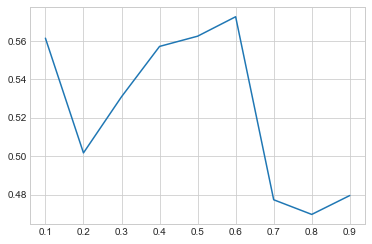

In [30]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rolling_mean,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### 7th Experiment - SVC with LOGO (RSSI)
Experiment using cross validation approach of Leave One Group Out

In [31]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rssi,train_Y.ravel(),groups=default_groups)
loo = compute_SVM_with_Classifier(testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

mae  mse  rmse  precision  accuracy  f1-score
0  1.0  1.0   1.0        0.0       0.0       0.0

#### 8th Experiment - SVC with LOGO (Rolling Mean)
Experiment using cross validation approach of Leave One Group Out

In [32]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rssi,train_Y.ravel(),groups=default_groups)
loo = compute_SVM_with_Classifier(testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

mae  mse  rmse  precision  accuracy  f1-score
0  1.0  1.0   1.0        0.0       0.0       0.0

#### 9th Experiment - Best cross-validation technique
Best parameters found using SVC

mae       mse      rmse  precision  accuracy  f1-score  \
4  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442   
1  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075   
2  0.514100  0.514100  0.717008   0.485546  0.485900  0.449274   
5  0.527115  0.527115  0.726027   0.495182  0.472885  0.463710   
0  1.000000  1.000000  1.000000   0.000000  0.000000  0.000000   
3  1.000000  1.000000  1.000000   0.000000  0.000000  0.000000   

              method               type  
4            HoldOut  Rolling Mean RSSI  
1            HoldOut          RSSI Only  
2  Stratified K-Fold          RSSI Only  
5  Stratified K-Fold  Rolling Mean RSSI  
0                LOO          RSSI Only  
3                LOO  Rolling Mean RSSI

Selected cross validation method:  HoldOut


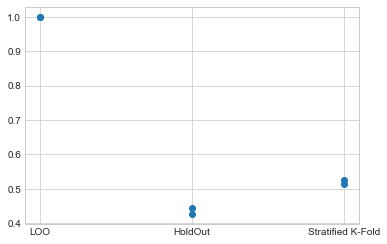

In [34]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.6, random_state = 6,stratify=default_groups)
    holdout = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
    loo = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(scannedType)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(scannedType)
    results.append(holdout)
    skfold = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold)
    skfold.append('Stratified K-Fold')
    skfold.append(scannedType)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'],'o')
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### 10th Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

mae       mse      rmse  precision  accuracy  f1-score  \
4  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442   
5  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442   
6  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442   
7  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442   
0  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075   
1  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075   
2  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075   
3  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075   

    preprocessing                                  preprocessingFunc  \
4  StandardScaler  StandardScaler(copy=True, with_mean=True, with...   
5    MinMaxScaler      MinMaxScaler(copy=True, feature_range=(0, 1))   
6    MaxAbsScaler                            MaxAbsScaler(copy=True)   
7            None                                               None   
0  StandardScaler  StandardScaler(copy=True, with_mean=True, with...   
1    MinMaxScaler      MinMaxScaler(copy=True, feature_range=(0, 1))   
2    MaxAbsScaler                            MaxAbsScaler(copy=True)   
3            None                                               None   

                type  
4  Rolling Mean RSSI  
5  Rolling Mean RSSI  
6  Rolling Mean RSSI  
7  Rolling Mean RSSI  
0          RSSI Only  
1          RSSI Only  
2          RSSI Only  
3          RSSI Only

Selected Preprocessing:  StandardScaler


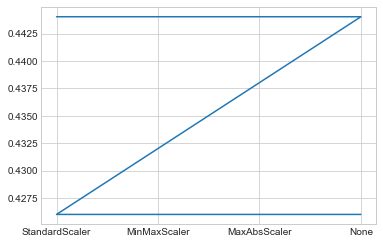

In [36]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.6, random_state = 6,stratify=default_groups)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### 11th Experiment - Running the SVC function with the different kernels

D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


mae       mse      rmse  precision  accuracy  f1-score   kernel  \
6  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442      rbf   
2  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075      rbf   
0  0.483755  0.483755  0.695525   0.429113  0.516245  0.445237   linear   
1  0.498195  0.498195  0.705829   0.560007  0.501805  0.464640     poly   
4  0.498195  0.498195  0.705829   0.421379  0.501805  0.434412   linear   
5  0.498195  0.498195  0.705829   0.548091  0.501805  0.461243     poly   
3  0.512635  0.512635  0.715986   0.504402  0.487365  0.422616  sigmoid   
7  0.545126  0.545126  0.738327   0.356567  0.454874  0.375535  sigmoid   

                type  
6  Rolling Mean RSSI  
2          RSSI Only  
0          RSSI Only  
1          RSSI Only  
4  Rolling Mean RSSI  
5  Rolling Mean RSSI  
3          RSSI Only  
7  Rolling Mean RSSI

Selected Kernel:  rbf


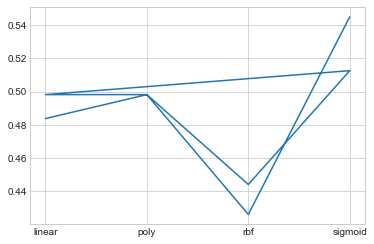

In [38]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','kernel','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for kernel in kernel_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                kernel_parameter=kernel)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                kernel_parameter=kernel)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.6, random_state = 6,stratify=default_groups)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),kernel_parameter=kernel)
        result.append(kernel)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['kernel'],statistics['mae'])
selected_kernel = statistics.sort_values(by=['mae'])['kernel'].head(1).values[0]
print("Selected Kernel: ",selected_kernel)

#### 12th Experiment - Running the SVC function with the different C parameters

D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


mae       mse      rmse  precision  accuracy  f1-score  C_parameter  \
8   0.425993  0.425993  0.652681   0.619236  0.574007  0.572442         1.00   
7   0.433213  0.433213  0.658189   0.578874  0.566787  0.536436         0.50   
2   0.444043  0.444043  0.666366   0.608856  0.555957  0.537075         1.00   
3   0.444043  0.444043  0.666366   0.588040  0.555957  0.554383        10.00   
1   0.447653  0.447653  0.669069   0.576918  0.552347  0.546869         0.50   
4   0.447653  0.447653  0.669069   0.571792  0.552347  0.547664       100.00   
9   0.447653  0.447653  0.669069   0.600813  0.552347  0.554437        10.00   
5   0.451264  0.451264  0.671762   0.569609  0.548736  0.537968      1000.00   
10  0.454874  0.454874  0.674443   0.582629  0.545126  0.544166       100.00   
6   0.458484  0.458484  0.677114   0.478280  0.541516  0.476894         0.25   
11  0.458484  0.458484  0.677114   0.571303  0.541516  0.536986      1000.00   
0   0.462094  0.462094  0.679775   0.465126  0.537906  0.471594         0.25   

                 type  
8   Rolling Mean RSSI  
7   Rolling Mean RSSI  
2           RSSI Only  
3           RSSI Only  
1           RSSI Only  
4           RSSI Only  
9   Rolling Mean RSSI  
5           RSSI Only  
10  Rolling Mean RSSI  
6   Rolling Mean RSSI  
11  Rolling Mean RSSI  
0           RSSI Only

Selected C Parameter:  1.0


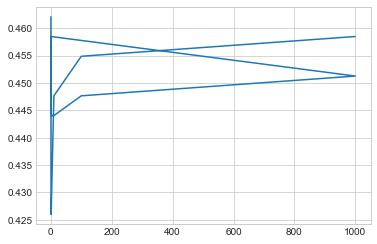

In [40]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','C_parameter','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for C_param in C_parameter_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                C_parameter=C_param)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,C_parameter=C_param)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.6, random_state = 6,stratify=default_groups)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),C_parameter=C_param)
        result.append(C_param)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['C_parameter'],statistics['mae'])
selected_c_parameter = statistics.sort_values(by=['mae'])['C_parameter'].head(1).values[0]
print("Selected C Parameter: ",selected_c_parameter)

#### 13th Experiment - Running the SVC function with the different gamma parameters

mae       mse      rmse  precision  accuracy  f1-score  gamma  \
6  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442  scale   
7  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442   auto   
5  0.429603  0.429603  0.655441   0.585492  0.570397  0.563513    100   
0  0.444043  0.444043  0.666366   0.577043  0.555957  0.546234     10   
2  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075  scale   
3  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075   auto   
4  0.458484  0.458484  0.677114   0.573073  0.541516  0.532100     10   
1  0.487365  0.487365  0.698115   0.509154  0.512635  0.482468    100   

  gammaStr               type  
6    scale  Rolling Mean RSSI  
7     auto  Rolling Mean RSSI  
5      100  Rolling Mean RSSI  
0       10          RSSI Only  
2    scale          RSSI Only  
3     auto          RSSI Only  
4       10  Rolling Mean RSSI  
1      100          RSSI Only

Selected Gamma Parameter:  scale


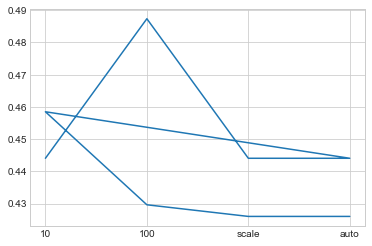

In [41]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','gamma','gammaStr','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for gamma_param in gamma_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                gamma_parameter=gamma_param)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,gamma_parameter=gamma_param)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.6, random_state = 6,stratify=default_groups)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),gamma_parameter=gamma_param)
        result.append(gamma_param)
        result.append(str(gamma_param))
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['gammaStr'],statistics['mae'])
selected_gamma = statistics.sort_values(by=['mae'])['gamma'].head(1).values[0]
print("Selected Gamma Parameter: ",selected_gamma)

#### 14th Experiment - Running the SVC function with the different weights metrics

mae       mse      rmse  precision  accuracy  f1-score class_weights  \
3  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442          None   
2  0.433213  0.433213  0.658189   0.614565  0.566787  0.563410      balanced   
1  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075          None   
0  0.447653  0.447653  0.669069   0.606723  0.552347  0.533858      balanced   

                type  
3  Rolling Mean RSSI  
2  Rolling Mean RSSI  
1          RSSI Only  
0          RSSI Only

Selected Weight:  None


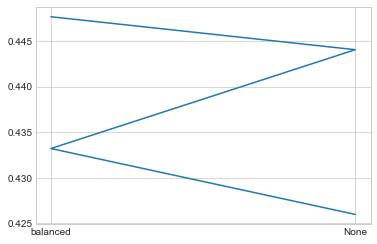

In [44]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','class_weights','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for weight in class_weights_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                class_weigth_parameter=weight)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,class_weigth_parameter=weight)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.6, random_state = 6,stratify=default_groups)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),class_weigth_parameter=weight)
        result.append(str(weight))
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['class_weights'],statistics['mae'])
selected_weight = statistics.sort_values(by=['mae'])['class_weights'].head(1).values[0]
print("Selected Weight: ",selected_weight)

#### 15th Experiment: Running the SVC function with the different decision function metrics

mae       mse      rmse  precision  accuracy  f1-score  \
2  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442   
3  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442   
0  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075   
1  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075   

  decision_function               type  
2               ovo  Rolling Mean RSSI  
3               ovr  Rolling Mean RSSI  
0               ovo          RSSI Only  
1               ovr          RSSI Only

Selected Decision:  ovo


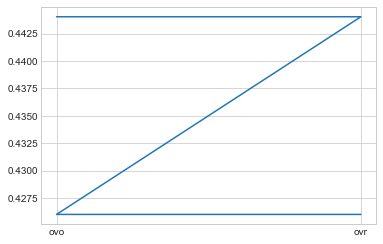

In [45]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','decision_function','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for decision in decision_function_shape_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                decision_function_shape_parameter=decision)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,decision_function_shape_parameter=decision)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.6, random_state = 6,stratify=default_groups)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),decision_function_shape_parameter=decision)
        result.append(str(decision))
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['decision_function'],statistics['mae'])
selected_decision = statistics.sort_values(by=['mae'])['decision_function'].head(1).values[0]
print("Selected Decision: ",selected_decision)

### Run GridSearch for parameter tunning

In [46]:
results = []
tuned_parameters = {
    'svc__kernel':['rbf'],
    'svc__C':C_parameter_list,
    'svc__gamma':gamma_list
}
scores = ['f1_macro']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    pipe = Pipeline([('standardizer', StandardScaler()), ('svc', SVC())])
    clf = GridSearchCV(
       pipe, tuned_parameters, cv=selected_fold,scoring=score,n_jobs=-1,verbose=1
    )
    clf.fit(train_X_rolling_mean,train_Y.ravel())
    clf.best_params_['score'] = score
    results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results)
display(gridcv_results)

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.5s finished


svc__C svc__gamma svc__kernel     score
0     0.5      scale         rbf  f1_macro

### Best Parameters
Display the best parameters tunned throughout the experiments

In [48]:
conclusion_cols=['C Parameter','Cross Validation','Kernel','Preprocessing','Gamma','Class Weights','Decision Function']
conclusion_list = [selected_c_parameter,selected_method,selected_kernel,selected_preprocessing,selected_gamma,selected_weight,
                  selected_decision]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

C Parameter Cross Validation Kernel   Preprocessing  Gamma Class Weights  \
0          1.0          HoldOut    rbf  StandardScaler  scale          None   

  Decision Function  
0               ovo

### Best Results
Compute SVC with the best parameters in both RSSI and Rolling Mean

In [50]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
        result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             gamma_parameter=selected_gamma,decision_function_shape_parameter=selected_decision)  
    elif selected_method =='Stratified K-Fold':
        result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold,
                            kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             gamma_parameter=selected_gamma,decision_function_shape_parameter=selected_decision)
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.6, random_state = 6,stratify=default_groups)
        result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                             scaler=StandardScaler(),kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             gamma_parameter=selected_gamma,decision_function_shape_parameter=selected_decision)
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('SVM Classification')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../proximity_results.csv',mode='a',index=False,header=False)

mae       mse      rmse  precision  accuracy  f1-score  \
1  0.425993  0.425993  0.652681   0.619236  0.574007  0.572442   
0  0.444043  0.444043  0.666366   0.608856  0.555957  0.537075   

                type  
1  Rolling Mean RSSI  
0          RSSI Only

### Best Results - Testing data being 1000 plot points
Experiment with testing data of 1000 plot points

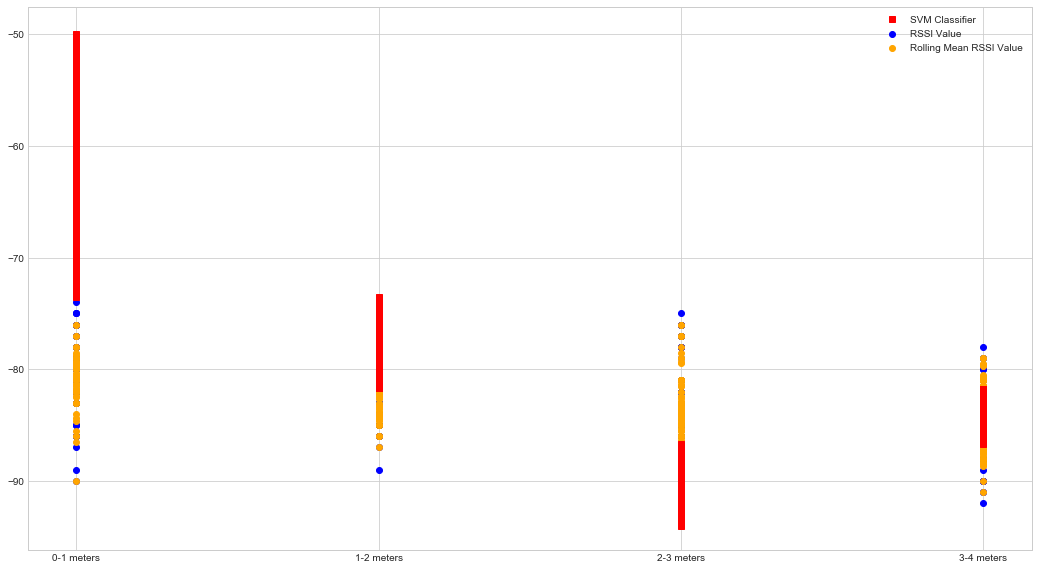

In [52]:
testX_data = np.linspace(dataset['rssi_Value'].min(), dataset['rssi_Value'].max(), 1000).reshape(-1,1)
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
svc_estimator = SVC()
main_estimator = make_pipeline(StandardScaler(),svc_estimator)
main_estimator.fit(train_X_rssi,train_Y.ravel())
predict_test = main_estimator.predict(testX_data)
plt.show()
plt.figure(figsize=(18,10))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.plot(predict_test, testX_data,'s',color='red', label='SVM Classifier')
# Show and place the legent
plt.legend(loc='upper right')
plt.show()